# Bank churners predictions

Given a customer's profile, predict if the customer is going to churn or not. With this information, bank managers can better prevent them from leaving the service and potentiall increase the retention rate.

In [282]:
from   category_encoders          import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from   sklearn.compose           import *
from   sklearn.ensemble          import RandomForestClassifier # ExtraTreesClassifier, IsolationForest
from   sklearn.ensemble          import GradientBoostingClassifier
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute            import *
from   sklearn.linear_model      import LogisticRegression# PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from   sklearn.metrics           import roc_auc_score 
from   sklearn.pipeline          import Pipeline
from   sklearn.preprocessing     import *
from   sklearn.tree              import DecisionTreeClassifier
from   sklearn.ensemble          import GradientBoostingClassifier
from sklearn.base            import BaseEstimator
from   sklearn.model_selection  import RandomizedSearchCV
from sklearn.metrics         import f1_score
from   sklearn.metrics          import accuracy_score
from   sklearn.metrics          import confusion_matrix
from   sklearn.metrics          import plot_roc_curve
from   sklearn.metrics          import roc_auc_score
from   sklearn.metrics          import average_precision_score
from   sklearn.metrics          import plot_precision_recall_curve
from   sklearn.model_selection  import train_test_split
from   sklearn.decomposition    import PCA
from   sklearn.metrics          import classification_report
from   feature_importance       import FeatureImportance
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')

### project idea:

1: Initial EDA with some visualizations, explore if some columns are correlated, some statistical test 


2: Feature select (select certain numeric and categorical data

Use pipeline to impute,scale, random search with cross validaiton and fit multiple models

3: After fitting the model and plot the feature importance (2nd location to have visualizations)

4: Repeat step 2 after getting the feature importance

5: Evaluation metric 

In [241]:
# class DummyEstimator(BaseEstimator):
#     "Pass through class, methods are present but do nothing."
#     def fit(self): pass
#     def score(self): pass

In [242]:
def evaluate_model(y_test,y_pred,pipe):

    print(classification_report(y_test, y_pred))


    print("Hold out set confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
#     y_scores = pipe.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_scores)
#     print("\nHold out AUC: ", np.round(auc, 3))

# Load the data and proform initial EDA

In [243]:
data = pd.read_csv('data/BankChurners.csv')

In [244]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [245]:
# check if there is any missing value in the dataseet
# data.isna().any()

In [246]:
# Check the ratio of existing customers and attrited(churned) customers
churn_ratio_df = data.groupby(['Attrition_Flag'])[
    ['CLIENTNUM']].count().reset_index()

churn_by_gender = data.groupby(['Attrition_Flag', 'Gender'])[['CLIENTNUM']].count(
).reset_index().sort_values(['Attrition_Flag', 'CLIENTNUM'], ascending=False)

churn_by_income = data.groupby(['Attrition_Flag', 'Income_Category'])[['CLIENTNUM']].count(
).reset_index().sort_values(['Attrition_Flag', 'CLIENTNUM'], ascending=False)

existing_customer_income = churn_by_income[churn_by_income['Attrition_Flag']
                                           == 'Existing Customer']

churned_customer_income = churn_by_income[churn_by_income['Attrition_Flag']
                                          == 'Attrited Customer']

churn_by_education = data.groupby(['Attrition_Flag', 'Education_Level'])[['CLIENTNUM']].count(
).reset_index().sort_values(['Attrition_Flag', 'CLIENTNUM'], ascending=False)

existing_customer_education = churn_by_education[churn_by_education['Attrition_Flag']
                                                 == 'Existing Customer']

churned_customer_education = churn_by_education[churn_by_education['Attrition_Flag']
                                                == 'Attrited Customer']

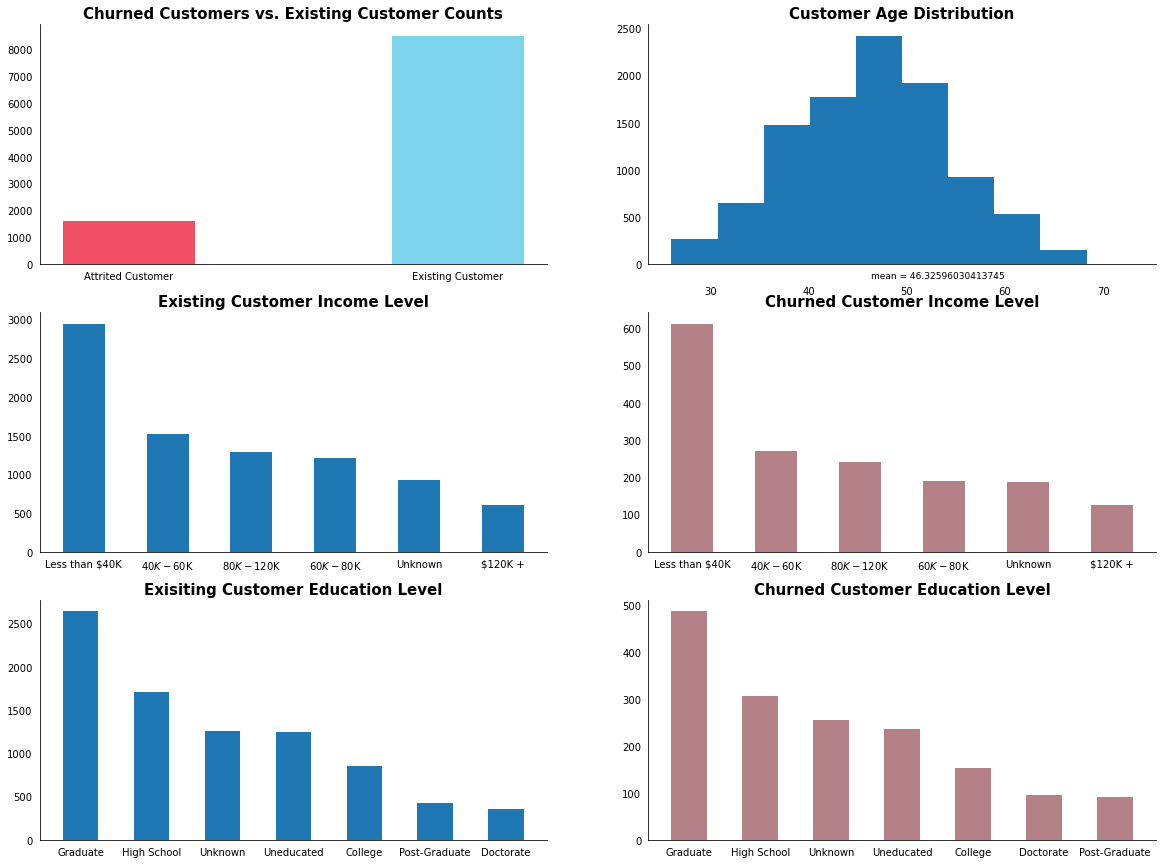

In [247]:
# Visualize the ratio
#fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

mx = data['Customer_Age'].mean()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()

axes[0].bar(churn_ratio_df['Attrition_Flag'],
            churn_ratio_df['CLIENTNUM'], color=['#f04f65', '#7ed3ed'], width=0.4)
axes[0].set_title(
    'Churned Customers vs. Existing Customer Counts', fontweight='bold', size=15)

axes[1].hist(data['Customer_Age'])
axes[1].set_title('Customer Age Distribution', fontweight='bold', size=15)
axes[1].text(mx, -150, f"mean = {mx}", fontsize=9)
axes[1].tick_params(axis='x', pad=18)

axes[2].bar(existing_customer_income['Income_Category'],
            existing_customer_income['CLIENTNUM'], width=0.5)
axes[2].set_title('Existing Customer Income Level', fontweight='bold', size=15)

axes[3].bar(churned_customer_income['Income_Category'],
            churned_customer_income['CLIENTNUM'], color='#b58188', width=0.5)
axes[3].set_title('Churned Customer Income Level', fontweight='bold', size=15)

axes[4].bar(existing_customer_education['Education_Level'],
            existing_customer_education['CLIENTNUM'], width=0.5)
axes[4].set_title('Exisiting Customer Education Level',
                  fontweight='bold', size=15)

axes[5].bar(churned_customer_education['Education_Level'],
            churned_customer_education['CLIENTNUM'], color='#b58188', width=0.5)
axes[5].set_title('Churned Customer Education Level',
                  fontweight='bold', size=15)

for i in range(6):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].yaxis.set_ticks_position('none')
    axes[i].xaxis.set_ticks_position('none')

From the visualizations above, the dataset is imbalanced. Churned customer count is much smaller then exisiting cosutomer count.

# Building the pipeline and fit the model

In [248]:
# if churn then 1, else 0
data['churn']=np.where(data.Attrition_Flag=='Existing Customer',0,1)

# split the X and y
X = data.drop(columns =['Attrition_Flag','churn'])
y = data[['churn']].values.ravel()

In [249]:
# split the train and split test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [250]:
# Define the categorical and numeric columns used in sklearn pipeline

categorical_columns = ['Gender', 'Education_Level',
                       'Marital_Status', 'Income_Category', 'Card_Category']
numeric_columns_draft = list(set(X_train.columns)-set(categorical_columns))

columns_to_remove = ['CLIENTNUM',
                     'Attrition_Flag',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

numeric_columns = [
    i for i in numeric_columns_draft if i not in columns_to_remove]

In [251]:
# Build pipeline for traning the model

con_pipe = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler()),
                     ('pca', PCA(n_components=14))])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
                     ('ode', OrdinalEncoder(handle_unknown='ignore'))])

preprocessing = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('continues', con_pipe, numeric_columns)])

# Model 1: Logistic Regression

In [252]:
pipe_lr = Pipeline([('prep', preprocessing),
                    ('clf', LogisticRegression())])

hyperparamters = {'clf__penalty': ['l1', 'l2'],
                  'clf__solver': ['newton_cg', 'liblinear', 'lbfgs'],
                  'clf__multi_class': ['auto', 'ovr', 'multinomial'],
                  'clf__class_weight': ['balanced'],
                  'prep__continues__pca__n_components': [6, 7, 10, 14, 17]}


# Hyperparameters turning with randomized search with 5-folds cross-validaiotion
lr_cv = RandomizedSearchCV(estimator=pipe_lr,
                           param_distributions=hyperparamters,
                           cv=10,
                           n_jobs=-1,
                           verbose=True)

lr_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent')),
                                                                                               ('ode',
                                                                                                OrdinalEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Education_Level',
                   

In [253]:
lr_cv.best_params_

{'prep__continues__pca__n_components': 7,
 'clf__solver': 'lbfgs',
 'clf__penalty': 'l2',
 'clf__multi_class': 'multinomial',
 'clf__class_weight': 'balanced'}

### Fit the final logistic regression model from the grid search result:


In [254]:
con_pipe = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler()),
                     ('pca', PCA(n_components=14))])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
                     ('ode', OrdinalEncoder(handle_unknown='ignore'))])

preprocessing_final = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('continues', con_pipe, numeric_columns)])

pipe_lr_final = Pipeline([('prep', preprocessing_final),
                    ('clf', LogisticRegression(solver='lbfgs',
                                               penalty='l2',
                                               multi_class='ovr',
                                               class_weight='balanced'))])

pipe_lr_final.fit(X_train, y_train)
y_pred=pipe_lr_final.predict(X_test)

### Evaluation metric on test set:

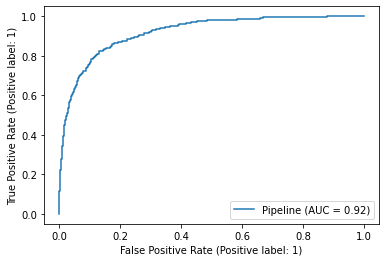

In [255]:
# AUC ROC curve 
plot_roc_curve(pipe_lr_final,X_test, y_test)
plt.show()

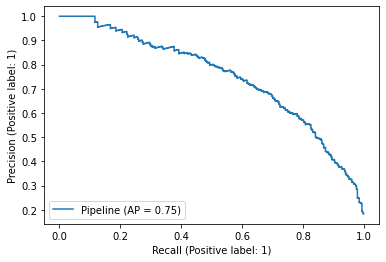

In [256]:
# PR curve, this is more reliable in class imbalance situation
disp = plot_precision_recall_curve(pipe_lr_final, X_test, y_test)

In [257]:
evaluate_model(y_test, y_pred, pipe_lr_final)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1692
           1       0.51      0.84      0.63       334

    accuracy                           0.84      2026
   macro avg       0.74      0.84      0.77      2026
weighted avg       0.89      0.84      0.85      2026

Hold out set confusion matrix:
[[1420  272]
 [  53  281]]


<AxesSubplot:>

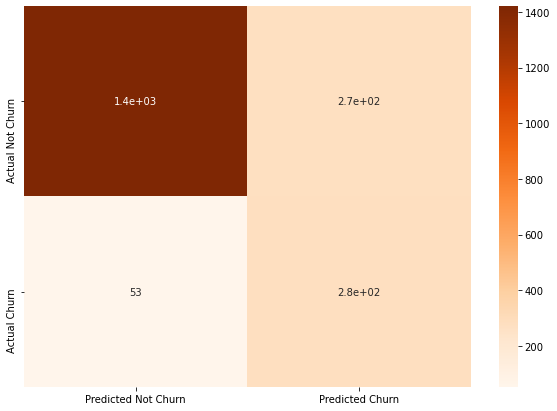

In [258]:
# Visualizae the confusion matrix (if churn then 1, else 0)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in ['Actual Not Churn','Actual Churn']],
                  columns = [i for i in ['Predicted Not Churn','Predicted Churn']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Oranges") 

# Model 2: RandomForestClassifier

In [259]:
pipe_rf = Pipeline([('prep', preprocessing),
                    ('clf', RandomForestClassifier())])

hyperparamters = {'clf__n_estimators': [10, 20, 30, 60, 100, 200],
                  'clf__min_samples_split': [3, 5, 10, 15, 20],
                  'clf__criterion': ['gini', 'entropy'],
                  'clf__class_weight': ['balanced', 'balanced_subsample'],
                  'clf__max_depth': [5, 6, 7, 8, 10],
                  'prep__continues__pca__n_components': [6, 7, 10, 14, 17]}


# Hyperparameters turning with randomized search with 5-folds cross-validaiotion
rf_cv = RandomizedSearchCV(estimator=pipe_rf,
                           param_distributions=hyperparamters,
                           cv=10,
                           n_jobs=-1,
                           verbose=True)

rf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent')),
                                                                                               ('ode',
                                                                                                OrdinalEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Education_Level',
                   

In [260]:
rf_cv.best_params_

{'prep__continues__pca__n_components': 10,
 'clf__n_estimators': 60,
 'clf__min_samples_split': 10,
 'clf__max_depth': 8,
 'clf__criterion': 'gini',
 'clf__class_weight': 'balanced_subsample'}

### Fit the final random forest classifier model from the grid search result:


In [261]:
con_pipe = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler()),
                     ('pca', PCA(n_components=14))])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
                     ('ode', OrdinalEncoder(handle_unknown='ignore'))])

preprocessing_final = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('continues', con_pipe, numeric_columns)])

pipe_rf_final = Pipeline([('prep', preprocessing_final),
                    ('clf', RandomForestClassifier(n_estimators=60,
                                                   min_samples_split=20,
                                                   max_depth=8,
                                                   criterion='entropy',
                                                   class_weight='balanced'))])
pipe_rf_final.fit(X_train, y_train)
y_pred=pipe_rf_final.predict(X_test)

### Evaluation metric on test set:

In [262]:
# churn is 1, non-churn is 0.
len(y_pred),np.count_nonzero(y_pred)

(2026, 388)

In [263]:
evaluate_model(y_test, y_pred, pipe_rf_final)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1692
           1       0.68      0.78      0.73       334

    accuracy                           0.90      2026
   macro avg       0.82      0.85      0.83      2026
weighted avg       0.91      0.90      0.91      2026

Hold out set confusion matrix:
[[1566  126]
 [  72  262]]


<AxesSubplot:>

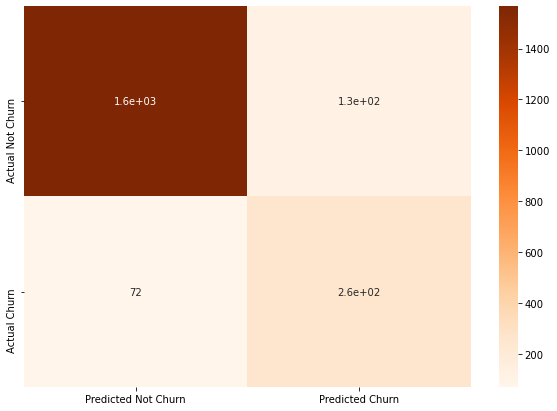

In [264]:
# Visualizae the confusion matrix (if churn then 1, else 0)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in ['Actual Not Churn','Actual Churn']],
                  columns = [i for i in ['Predicted Not Churn','Predicted Churn']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Oranges") 

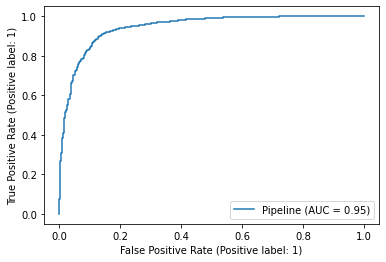

In [265]:
# AUC ROC curve 
plot_roc_curve(pipe_rf_final,X_test, y_test)
plt.show()

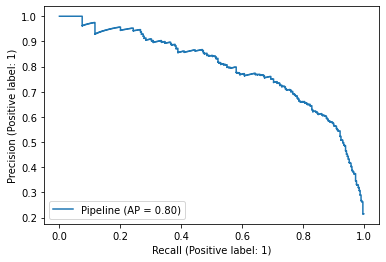

In [266]:
# PR curve, this is more reliable in class imbalance situation
disp = plot_precision_recall_curve(pipe_rf_final, X_test, y_test)

### Get the feature importance and plot it from random forest classifier:

In [267]:
# https://www.kaggle.com/kylegilde/extracting-scikit-feature-names-importances
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
from feature_importance import FeatureImportance

In [279]:
feature_importance = FeatureImportance(pipe_rf_final)
feature_importance.plot(top_n_features=20)

###### Just by comparing average PR score and PR curve on the test set, random forest outperform logistic regression.

From the feature importance plots from random forest 

In [269]:
# pipe_rf_final[-1].feature_importances_

# Model 3: GradientBoostingClassifier

In [270]:
pipe_GB = Pipeline([('prep', preprocessing),
                    ('clf', GradientBoostingClassifier())])

hyperparamters = {'clf__loss': ['deviance','exponential'],
                  'clf__n_estimators': [80,100,120,150],
                  'clf__subsample': [0.5,0.8,1],
                  'clf__min_samples_split': [5,10,15,20],
                  'clf__max_depth': [2,3,4,5,6, 7, 8, 10],
                  'clf__min_weight_fraction_leaf': [0.3,0.5,0.7,0],
                  'prep__continues__pca__n_components': [6, 7, 10, 14, 17]}


# Hyperparameters turning with randomized search with 5-folds cross-validaiotion
GB_cv = RandomizedSearchCV(estimator=pipe_GB,
                           param_distributions=hyperparamters,
                           cv=10,
                           n_jobs=-1,
                           verbose=True)

GB_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='most_frequent')),
                                                                                               ('ode',
                                                                                                OrdinalEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'Education_Level',
                   

In [271]:
GB_cv.best_params_

{'prep__continues__pca__n_components': 14,
 'clf__subsample': 0.5,
 'clf__n_estimators': 80,
 'clf__min_weight_fraction_leaf': 0,
 'clf__min_samples_split': 15,
 'clf__max_depth': 5,
 'clf__loss': 'exponential'}

In [272]:
con_pipe = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler()),
                     ('pca', PCA(n_components=14))])

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
                     ('ode', OrdinalEncoder(handle_unknown='ignore'))])

preprocessing_final = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                   ('continues', con_pipe, numeric_columns)])

pipe_GB_final = Pipeline([('prep', preprocessing_final),
                    ('clf', GradientBoostingClassifier(subsample=0.8,
                                                      n_estimators=80,
                                                      min_weight_fraction_leaf=0,
                                                      min_samples_split=10,
                                                      max_depth=5,
                                                      loss='deviance'))])
pipe_GB_final.fit(X_train, y_train)
y_pred=pipe_GB_final.predict(X_test)

In [273]:
len(y_pred),np.count_nonzero(y_pred)

(2026, 270)

In [274]:
evaluate_model(y_test, y_pred, pipe_GB_final)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1692
           1       0.83      0.67      0.74       334

    accuracy                           0.92      2026
   macro avg       0.88      0.82      0.85      2026
weighted avg       0.92      0.92      0.92      2026

Hold out set confusion matrix:
[[1646   46]
 [ 110  224]]


<AxesSubplot:>

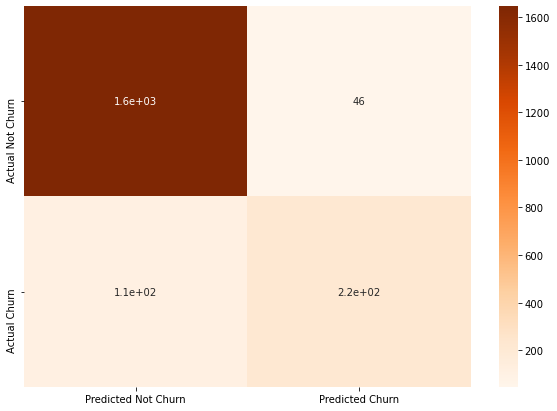

In [275]:
# Visualizae the confusion matrix (if churn then 1, else 0)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = [i for i in ['Actual Not Churn','Actual Churn']],
                  columns = [i for i in ['Predicted Not Churn','Predicted Churn']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Oranges") 

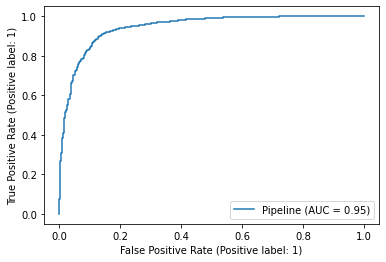

In [276]:
# AUC ROC curve 
plot_roc_curve(pipe_rf_final,X_test, y_test)
plt.show()

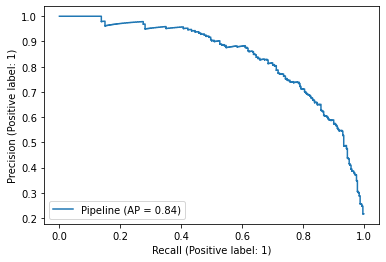

In [277]:
# PR curve, this is more reliable in class imbalance situation
disp = plot_precision_recall_curve(pipe_GB_final, X_test, y_test)

###### Just by comparing average PR score and PR curve on the test set, gradient boosting outperforms random forest

In [283]:
feature_importance = FeatureImportance(pipe_GB_final)
feature_importance.plot(top_n_features=20)

#### The most important features and least important features for random forest and gradient boosting classifiers are similar.

